# Develop `tracer_thalweg_and_surface` Figure Module

Development of functions for `nowcast.figures.research.tracer_thalweg_and_surface` web site figure module.

This is an example of developing the functions for a web site figure module in a notebook.
It follows the function organization patterns described in
[Creating a Figure Module](https://salishsea-nowcast.readthedocs.io/en/latest/figures/create_fig_module.html) docs.

If you choose to develop your figure in a notebook,
the next step is to create a module like
`nowcast.figures.research.tracer_thalweg_and_surface`
and a notebook like
[TestTracerThalwegAndSurfaceModule]()
that tests it in the nowcast system context.

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import salishsea_tools

import datetime
import os

from collections import namedtuple

import nowcast
import nowcast.figures.shared
import nowcast.figures.website_theme

from matplotlib import gridspec

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools, geo_tools)

%matplotlib inline

import scipy.io as sio
import pdb as pdb
#from nowcast.figures.research import tracer_thalweg_and_surface

In [2]:
def _prep_fig_axes(figsize, theme, two_cbars):
    fig = plt.figure(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor'])
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.14, 1])
        
    ax_thalweg = fig.add_subplot(gs[0])
    ax_thalweg.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    ax_surface = fig.add_subplot(gs[1])
    ax_surface.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    return fig, (ax_thalweg, ax_surface)

In [3]:
def _map_cbar_labels(cbar, contour_intervals, theme, label):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        label,
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis'])

In [13]:
def _plot_tracer_surface(ax, plot_data, cmap, theme):
    nowcast.figures.shared.plot_map(ax,plot_data.coastline, lon_range=plot_data.lon_range, lat_range=plot_data.lat_range)
    mesh = ax.contourf(plot_data.lons_subset, plot_data.lats_subset, plot_data.var_ma, levels=plot_data.surf_clevels, cmap=cmap, extend='both')
    
    ax.set_xlabel('Longitude', color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    ax.set_ylabel('Latitude', color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)
    
    cbar = plt.colorbar(mesh, ax=ax, fraction=0.034, pad=0.04)
    contour_intervals = plot_data.surf_clevels
    if(plot_data.depth_integrated == True):
        label = plot_data.tracer_name + " [" + plot_data.units + "*m]"
    else:
        label = plot_data.tracer_name + " [" + plot_data.units + "]"
    _map_cbar_labels(cbar, contour_intervals[::2], theme, label)

In [5]:
def _plot_tracer_thalweg(ax, plot_data, cmap, theme):
    cbar = vis.contour_thalweg(ax, plot_data.tracer_grid, plot_data.bathy, plot_data.lons, plot_data.lats, plot_data.mesh_mask, 'gdept', clevels=plot_data.thal_clevels, cmap=cmap, cbar_args={'fraction':0.030,'pad':0.04})
    #pdb.set_trace()
    viz_tools.set_aspect(ax)
    ax.set_ylim([450,0])
    if(plot_data.show_thalweg_cbar == False):
        cbar.remove()  
    else:
        contour_intervals = plot_data.thal_clevels
        label = plot_data.tracer_name + " [" + plot_data.units + "]"
        _map_cbar_labels(cbar, contour_intervals[::2], theme, label)
    ax.set_xlabel("Distance along thalweg [km]",color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    ax.set_ylabel("Depth [m]",color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)
    

In [6]:
def surf_thalweg_clevels(tracer_grid, surface_var):
    percent_98_surf = np.percentile(surface_var, 98)
    percent_2_surf = np.percentile(surface_var, 2)
    
    percent_98_grid = np.percentile(np.ma.masked_values(tracer_grid, 0), 98)
    percent_2_grid = np.percentile(np.ma.masked_values(tracer_grid, 0), 2)
    
    overlap = max(0, min(percent_98_surf, percent_98_grid) - max(percent_2_surf, percent_2_grid))
    magnitude = (percent_98_surf - percent_2_surf) + (percent_98_grid - percent_2_grid)
    if(2*overlap/magnitude > 0.5):
        max_clevel = max(percent_98_surf, percent_98_grid)
        min_clevel = min(percent_2_surf, percent_2_grid)
        thal_clevels = np.arange(min_clevel, max_clevel, (max_clevel - min_clevel)/20.0)
        surf_clevels = thal_clevels
        show_thalweg_cbar = False
    else:
        thal_clevels = np.arange(percent_2_grid, percent_98_grid, (percent_98_grid - percent_2_grid)/20.0)
        surf_clevels = np.arange(percent_2_surf, percent_98_surf, (percent_98_surf - percent_2_surf)/20.0)
        show_thalweg_cbar = True
    return([thal_clevels, surf_clevels, show_thalweg_cbar])

In [11]:
def _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline, depth_integrated):
    lon_range = (-124.4, -122.4)
    lat_range = (48, 49.6)
    si, ei = 150, 610
    sj, ej = 20, 370   
    
    lons_subset = lons[si:ei, sj:ej]
    lats_subset = lats[si:ei, sj:ej]
    if depth_integrated:
        grid_heights = mesh_mask.variables['e3t_0'][:][0].reshape(40,1,1)
        height_weighted = tracer_grid[0, :, si:ei, sj:ej]*grid_heights
        surface_var = height_weighted.sum(axis=0)
    else:
        surface_var = tracer_grid[0, 0, si:ei, sj:ej]
    surface_var = np.ma.masked_array(surface_var, 1 - mesh_mask["tmask"][0, 0, si:ei, sj:ej])
    
    thal_clevels, surf_clevels, show_thalweg_cbar = surf_thalweg_clevels(tracer_grid, surface_var)
    
    if 'standard_name' in tracer_grid.ncattrs():
        tracer_name = tracer_grid.standard_name
    elif 'long_name' in tracer_grid.ncattrs():
        tracer_name = tracer_grid.long_name
    else:
        tracer_name = "Var"

    plot_data = namedtuple(
        'PlotData',
        'tracer_grid, var_ma, bathy '
        'lons, lats, lons_subset, lats_subset ' 
        'mesh_mask, coastline '
        'lon_range, lat_range '
        'thal_clevels, surf_clevels '
        'show_thalweg_cbar, tracer_name '
        'units, depth_integrated'
    )
    
    return plot_data(
        tracer_grid=tracer_grid[0,:,:,:],
        var_ma=surface_var,
        bathy=bathy,
        lons=lons,
        lats=lats,
        lons_subset=lons_subset,
        lats_subset=lats_subset,
        mesh_mask=mesh_mask,
        coastline=coastline,
        lon_range=lon_range,
        lat_range=lat_range,
        thal_clevels=thal_clevels,
        surf_clevels=surf_clevels,
        show_thalweg_cbar=show_thalweg_cbar,
        tracer_name=tracer_name,
        units=tracer_grid.units,
        depth_integrated=depth_integrated,
    )


In [8]:
def tracer_thalweg_and_surface(tracer_grid, bathy, lons, lats, mesh_mask, coastline,
                               depth_integrated = False,
                               figsize=(20, 12), theme=nowcast.figures.website_theme,
):  
    cmap = plt.get_cmap('jet')  # clevels, cmap = _color_map(tracer_name)
    
    plot_data = _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline, depth_integrated)
    fig, (ax_thalweg, ax_surface) = _prep_fig_axes(figsize, theme, plot_data.show_thalweg_cbar)
    _plot_tracer_thalweg(ax_thalweg, plot_data, cmap, theme)
    _plot_tracer_surface(ax_surface, plot_data, cmap, theme)
    
    fig.tight_layout()
    return(fig)


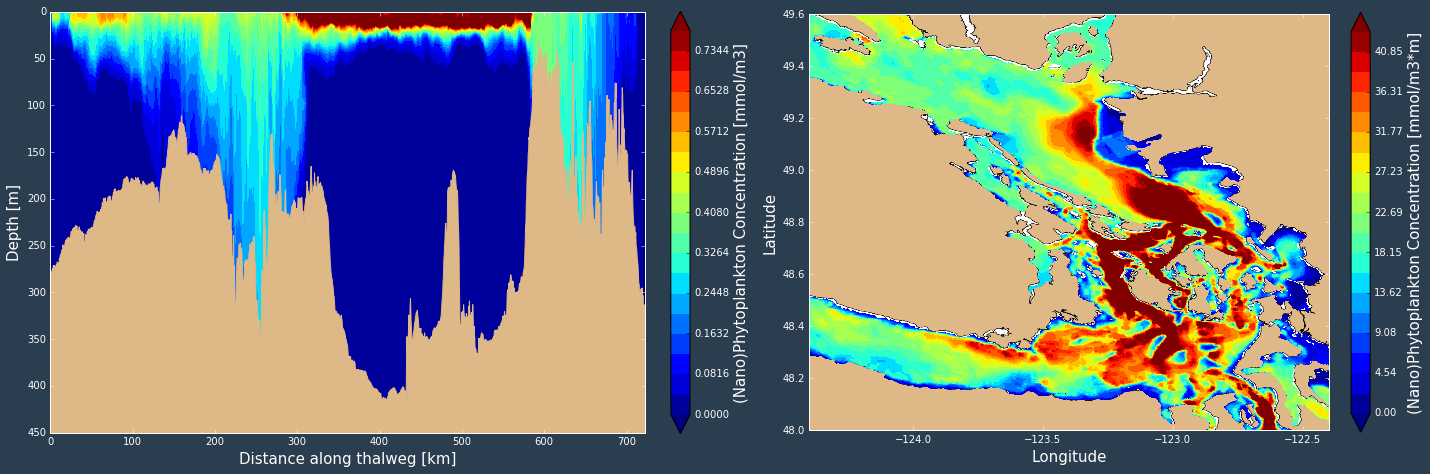

In [14]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

grid_T = nc.Dataset('/results/SalishSea/nowcast/01apr16/SalishSea_1d_20160401_20160401_grid_T.nc')
ptrc_T = nc.Dataset('/data/jpetrie/MEOPAR/SalishSea/results/full_domain/april12_55_iopt_diat/SalishSea_1h_20160412_20160412_ptrc_T.nc')

var = ptrc_T.variables['PHY2']

thalweg_and_surface_plot = tracer_thalweg_and_surface(var, bathy, lons, lats, mesh_mask, coastline, True)
plt.show(thalweg_and_surface_plot)

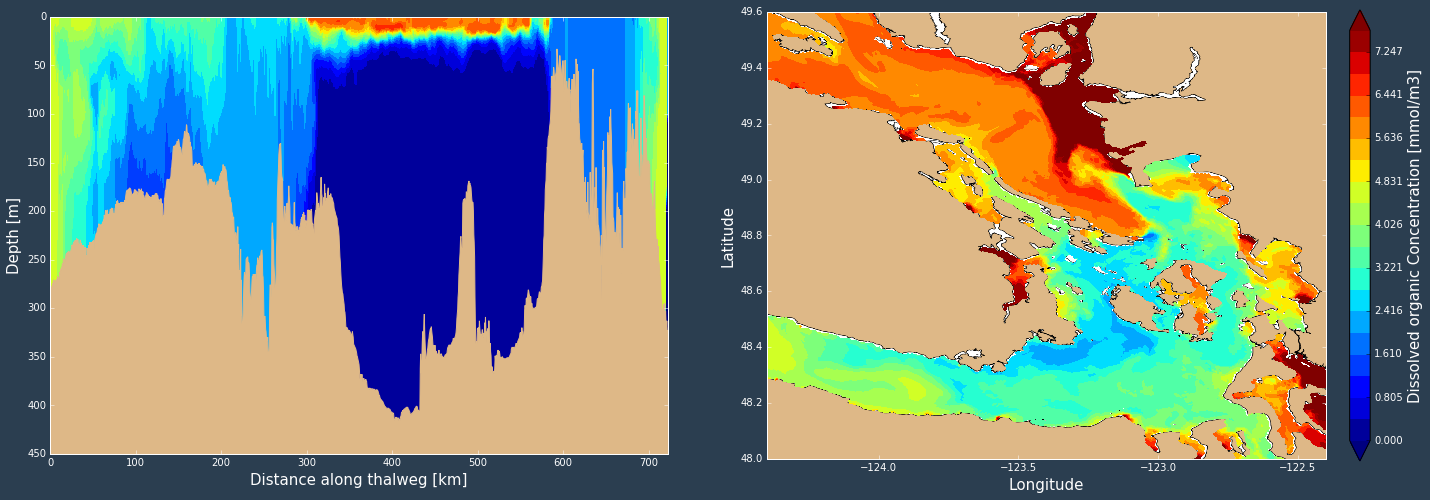

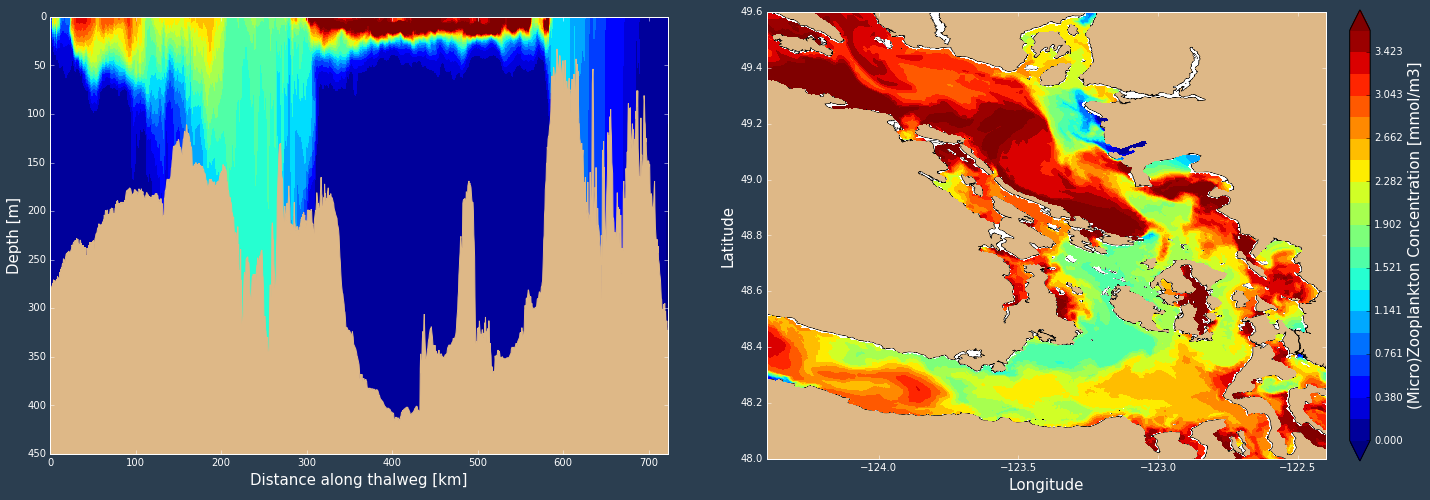

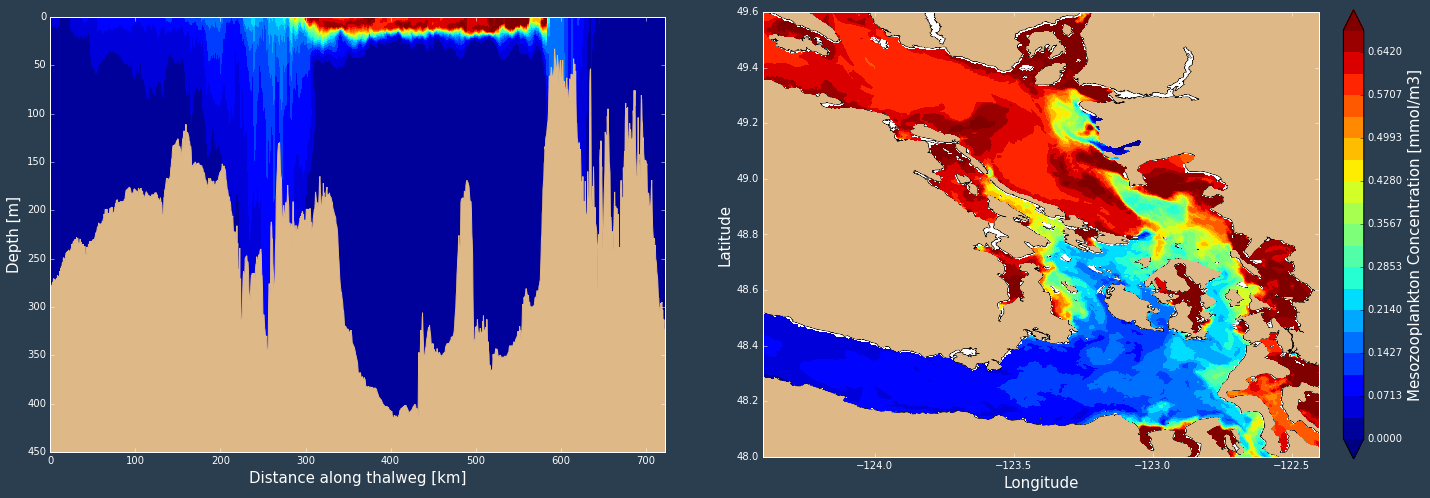

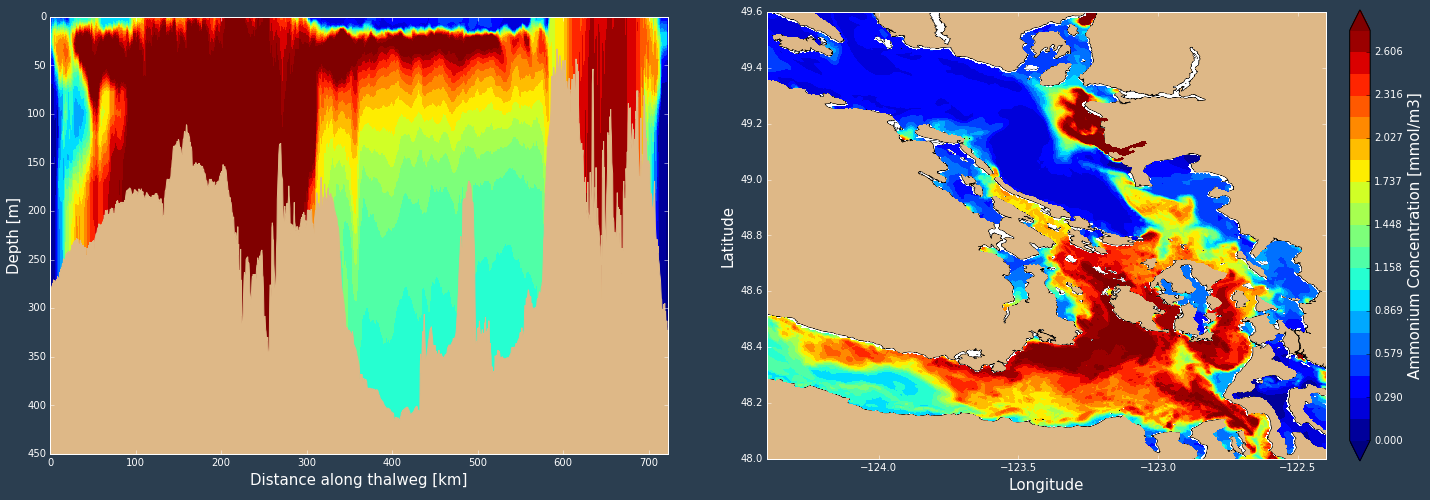

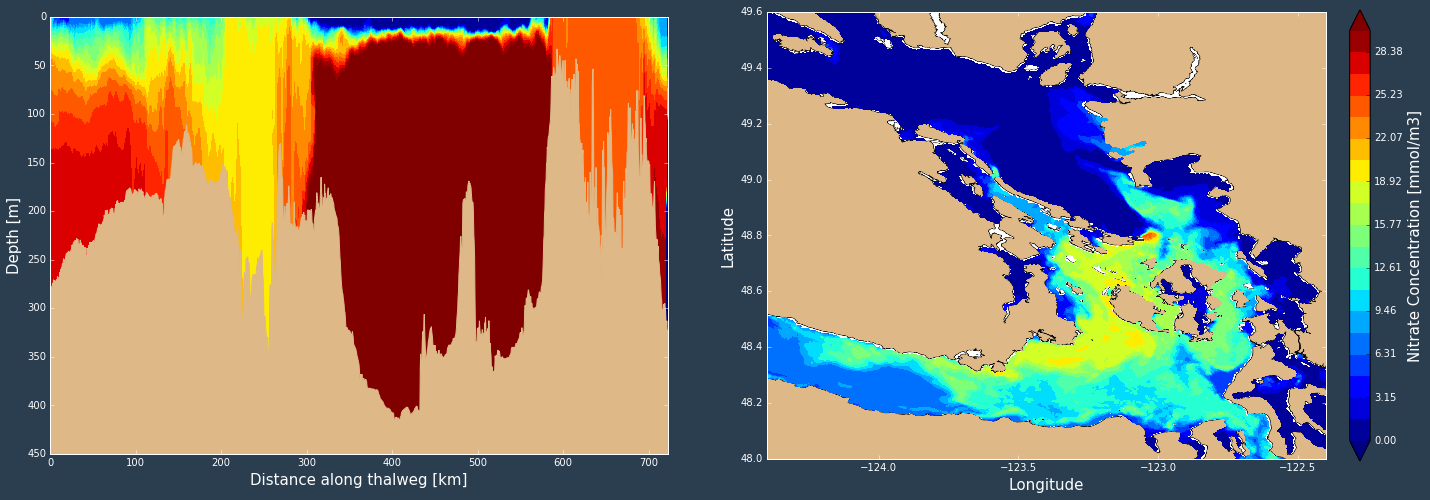

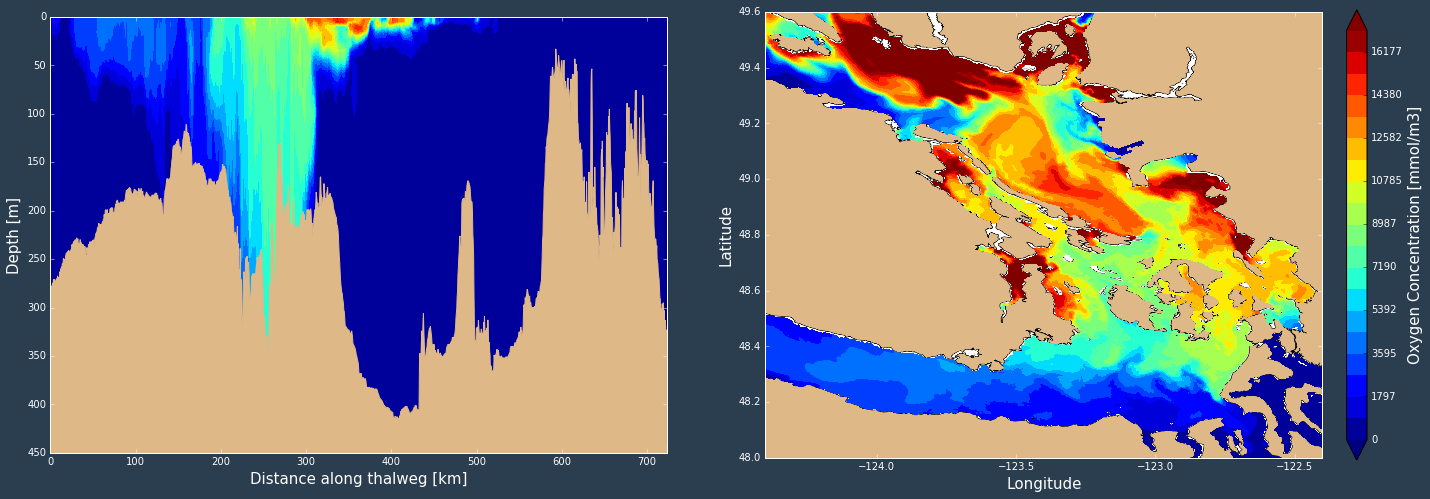

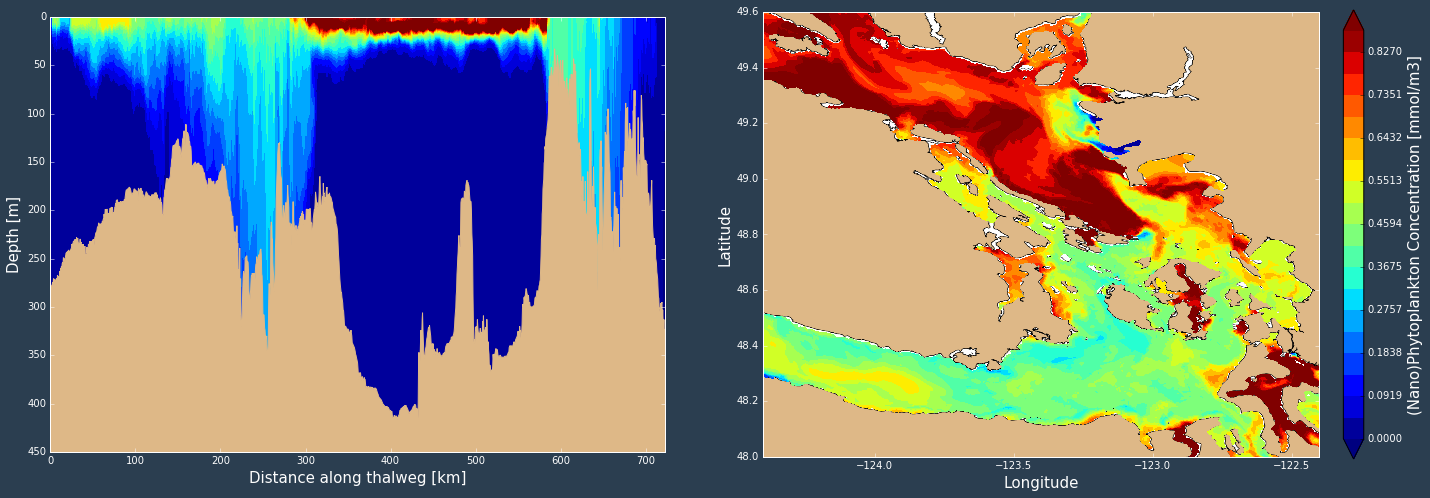

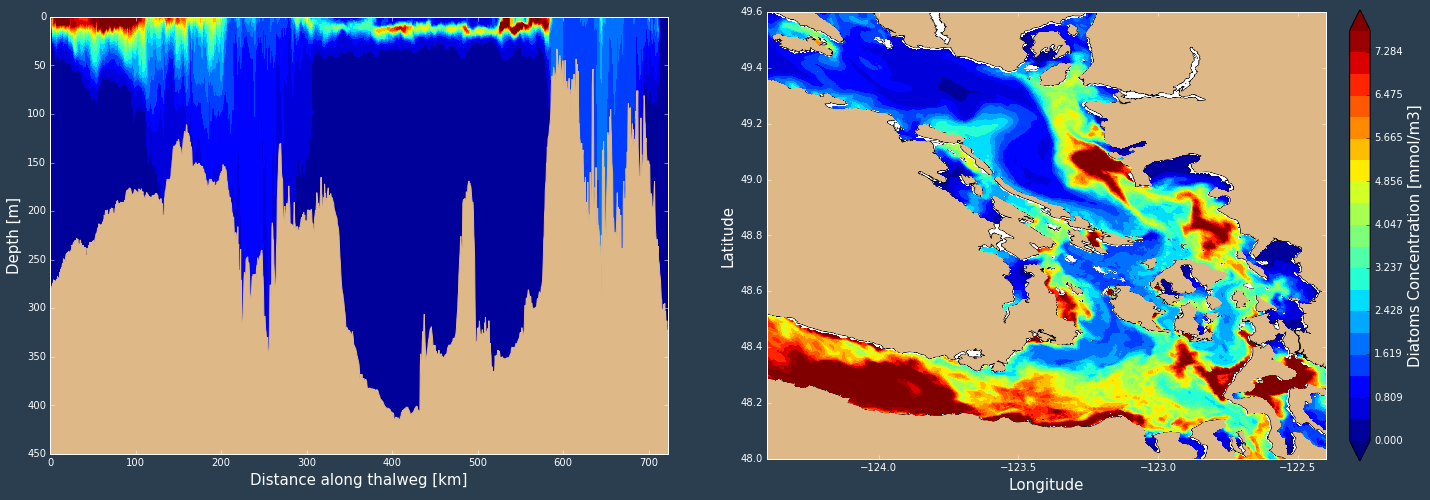

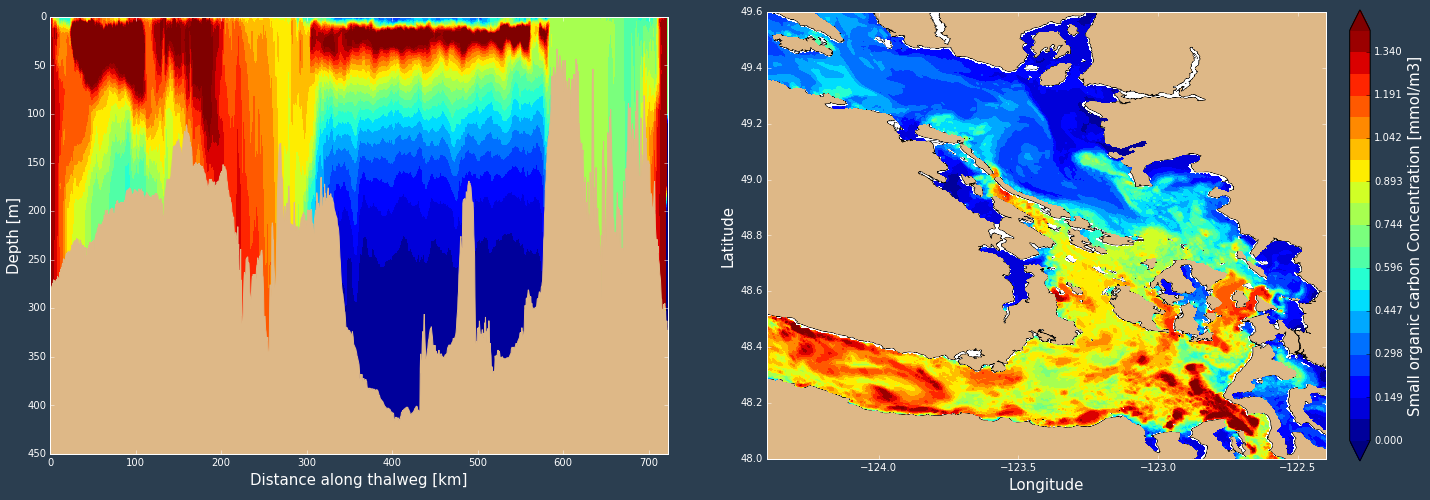

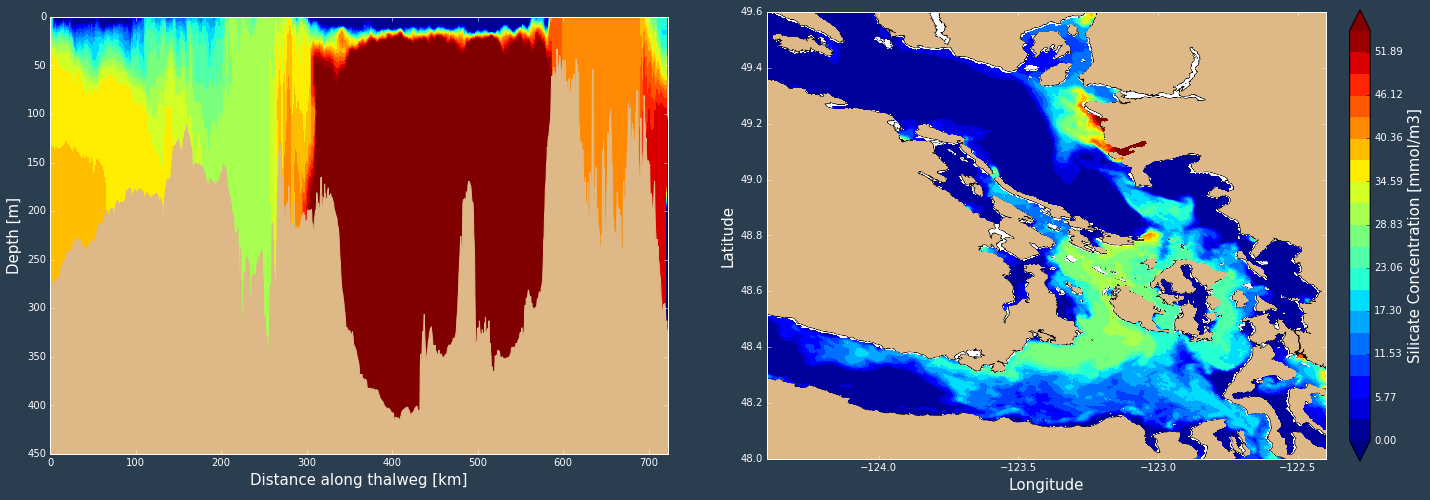

ValueError: slicing expression exceeds the number of dimensions of the variable

In [27]:
for tracer in ptrc_T.variables.keys():
    var = ptrc_T.variables[tracer]
    if(len(var.shape) == 4):
        thalweg_and_surface_plot = tracer_thalweg_and_surface(var, bathy, lons, lats, mesh_mask, coastline, False)
        plt.show(thalweg_and_surface_plot)

In [39]:
def f(a,b,c,e,d):
    print(a + b + c + d + e)

In [45]:
x = {'c':3,'d':4,'e':5}
if x:(1,2,**x)
else:f(1,2,3,4,6)

SyntaxError: invalid syntax (<ipython-input-45-072563436670>, line 2)